In [1]:
import requests
import pandas as pd
import json
import mysql.connector
import matplotlib.pyplot as plt

In [2]:
url = "https://data.cityofchicago.org/resource/c7ck-438e.json"

try:
    response = requests.get(url)
    data = response.json()
    # print(data)
    iucr = [x['iucr'] for x in data]
    primary_description = [x['primary_description'] for x in data]
    secondary_description = [x['secondary_description'] for x in data]
    secondary_description = [x['secondary_description'] for x in data]
    index_code = [x['index_code'] for x in data]
    active = [x['active'] for x in data]

except requests.exceptions.RequestException as e:
    print(f"Error: {e}")

data = {
            'iucr': iucr,
            'primary_description': primary_description,
            'secondary_description':secondary_description,
            'index_code': index_code,
            'active': active
        }

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

  iucr      primary_description     secondary_description index_code  active
0  110                 HOMICIDE       FIRST DEGREE MURDER          I    True
1  130                 HOMICIDE      SECOND DEGREE MURDER          I    True
2  141                 HOMICIDE  INVOLUNTARY MANSLAUGHTER          N    True
3  142                 HOMICIDE         RECKLESS HOMICIDE          N    True
4  261  CRIMINAL SEXUAL ASSAULT      AGGRAVATED - HANDGUN          I    True
(410, 5)


In [3]:
df.nunique()

iucr                     410
primary_description       33
secondary_description    384
index_code                 2
active                     2
dtype: int64

## Table columns
Now we have a dimension table to get more information about the crime types. This is a description of each column.

- **iucr:** This is the primary key of this table and the foreign key for the 'crimes' table. This code corresponds to the Illinois Uniform Crime Reporting which is used tp classify criminal incidents when creating a report.

- **primary_description:** This description gives us a category of the crime as a general description.

- **secondary_description:** This is a subtype of each category of the crime that gives more information about the incident.

- **index_code:** This index divides the crimes into two categories; "Index" and "Non-index"offenses. According to the chicago data portal, the index offenses include murder, criminal sexual assault, robbery, aggravated assault & battery, burglary, theft, motor vehicle theft, and arson. While the non-index offenses are all other types of criminal incidents, including vandalism, weapons violations, public peace violations, etc.

- **active:** This column shows whether the code is active. Retired codes (No) are present in this dataset for historical reference. Since our analysis covers crimes since 2001, there might have been crimes that occurred then that are now retired, so this column is important.


In [2]:
with open('config_db.json') as config_json:
    config = json.load(config_json)

conx = mysql.connector.connect(**config) 

In [13]:
mycursor = conx.cursor()

mycursor.execute("ALTER TABLE crimes DROP COLUMN primary_type, DROP COLUMN description")

query = "DESCRIBE crimes"
mycursor.execute(query)

description_table = mycursor.fetchall()

mycursor.close()

# we have seen the creation of the table 
desc_table=pd.DataFrame(description_table, columns=['Field', 'Type', 'Null', 'Key', 'Default', 'Extra'])
print(desc_table)

mycursor.close()

            Field             Type Null           Key Default Extra
0              id           b'int'   NO  [80, 82, 73]    None      
1            date          b'date'  YES            []    None      
2            time          b'time'  YES            []    None      
3           block  b'varchar(150)'  YES            []    None      
4            iucr   b'varchar(10)'  YES            []    None      
5   location_desc  b'varchar(150)'  YES            []    None      
6          arrest    b'tinyint(1)'  YES            []    None      
7        district           b'int'  YES            []    None      
8            year           b'int'  YES            []    None      
9      updated_on      b'datetime'  YES            []    None      
10       location         b'point'  YES            []    None      


False

### Insert dimension into DB

In [52]:
mycursor = conx.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS codes(iucr varchar(10) PRIMARY KEY,primary_description VARCHAR(50),secondary_description VARCHAR(70),index_code VARCHAR(5),active boolean)")

query = "DESCRIBE codes"
mycursor.execute(query)

description_table = mycursor.fetchall()

mycursor.close()

# we have seen the creation of the table 
desc_table=pd.DataFrame(description_table, columns=['Field', 'Type', 'Null', 'Key', 'Default', 'Extra'])
print(desc_table)


                   Field            Type Null  Key Default Extra
0                   iucr  b'varchar(10)'   NO  PRI    None      
1    primary_description  b'varchar(50)'  YES         None      
2  secondary_description  b'varchar(70)'  YES         None      
3             index_code   b'varchar(5)'  YES         None      
4                 active   b'tinyint(1)'  YES         None      


In [55]:
mycursor = conx.cursor()

# inserting into db
for index, row in df.iterrows():
    insert = "INSERT INTO codes (iucr, primary_description, secondary_description, index_code, active) VALUES (%s, %s, %s, %s, %s)"
    data = (row['iucr'], row['primary_description'], row['secondary_description'], row['index_code'], row['active'])
    mycursor.execute(insert, data)

conx.commit()

mycursor.close()

True

In [51]:
# #Delete table, just in case :)... delete because of varchar's lengths
# mycursor = conx.cursor()

# query = "DROP table iucr"
# mycursor.execute(query)

# mycursor.close()

True

When we saw the first rows of the dataframe of the data extracted form the API, we saw some inconsistencies in the iucr column. Let's check the values in our table.

In [3]:
mycursor = conx.cursor()

distinct_crimes = "SELECT DISTINCT iucr FROM crimes ORDER BY iucr DESC LIMIT 10"

mycursor.execute(distinct_crimes)
from_crimes = mycursor.fetchall()
mycursor.close()

crimes_iucr_df = pd.DataFrame(from_crimes, columns=['iucr'])

print(crimes_iucr_df)

   iucr
0  5132
1  5131
2  5130
3  5114
4  5112
5  5111
6  5110
7  502T
8  502R
9  502P


In [4]:
mycursor = conx.cursor()

distinct_iucr = "SELECT iucr FROM codes ORDER BY iucr DESC LIMIT 10"

mycursor.execute(distinct_iucr)
from_iucr = mycursor.fetchall()
mycursor.close()

iucr_df = pd.DataFrame(from_iucr, columns=['iucr'])

print(iucr_df)


  iucr
0  938
1  937
2  935
3  930
4  928
5  927
6  925
7  920
8  918
9  917


We can see that the values for the iucr column do not match for both tables. This is an issue because this is the link between both tables, it must be the same. Let's look more into this...

In [5]:
mycursor = conx.cursor()

three_char_iucr = "SELECT COUNT(iucr) FROM codes WHERE LENGTH(iucr) = 3"

mycursor.execute(three_char_iucr)
results = mycursor.fetchall()
mycursor.close()

three_char_iucr_df = pd.DataFrame(results, columns=['num_3_characters'])

print(three_char_iucr_df)

   num_3_characters
0               109


In [60]:
mycursor = conx.cursor()

three_char_crimes = "SELECT COUNT(iucr) FROM crimes WHERE LENGTH(iucr) = 3"

mycursor.execute(three_char_crimes)
results = mycursor.fetchall()
mycursor.close()

three_char_crimes_df = pd.DataFrame(results, columns=['num_3_characters'])

print(three_char_crimes_df)

   num_3_characters
0                 0


We can see that some values in the IUCR column have 3 characters, this is because the API where the data was extracted manages some codes with 3 characters whereas our Kaggle dataset contains minimum 4 characters for all IUCR codes and adds a 0 before the three character codes. Here we can see it with the first degree murder crime as an example

In [6]:
mycursor = conx.cursor()

homicide_iucr = "SELECT iucr, primary_description, secondary_description FROM codes WHERE iucr = '110'"

mycursor.execute(homicide_iucr)
results = mycursor.fetchall()
mycursor.close()

homicide_iucr_df = pd.DataFrame(results)

print(homicide_iucr_df)

     0         1                    2
0  110  HOMICIDE  FIRST DEGREE MURDER


In [63]:
mycursor = conx.cursor()

homicide_crimes = "SELECT iucr, primary_type, description FROM crimes WHERE iucr = '0110' LIMIT 1"

mycursor.execute(homicide_crimes)
results = mycursor.fetchall()
mycursor.close()

homicide_crimes_df = pd.DataFrame(results)

print(homicide_crimes_df)

      0         1                    2
0  0110  HOMICIDE  FIRST DEGREE MURDER


We can solve this through an SQL statement like the following:

In [7]:
mycursor = conx.cursor()

update = """UPDATE codes
           SET iucr = 
            CASE 
                WHEN LENGTH(iucr) = 3 THEN CONCAT('0', iucr)
                ELSE iucr
            END;"""

mycursor.execute(update)
conx.commit()
mycursor.close()

True

Now we can check that the query is correct by trying to find the three character codes and finding the IUCR '110' once again. This time neither should return anything.

In [8]:
mycursor = conx.cursor()

three_char_iucr = "SELECT COUNT(iucr) FROM codes WHERE LENGTH(iucr) = 3"

mycursor.execute(three_char_iucr)
results = mycursor.fetchall()
mycursor.close()

three_char_iucr_df = pd.DataFrame(results, columns=['num_3_characters'])

print(three_char_iucr_df)

   num_3_characters
0                 0


In [9]:
mycursor = conx.cursor()

homicide_iucr = "SELECT iucr, primary_description, secondary_description FROM codes WHERE iucr = '110'"

mycursor.execute(homicide_iucr)
results = mycursor.fetchall()
mycursor.close()

homicide_iucr_df = pd.DataFrame(results)

print(homicide_iucr_df)

Empty DataFrame
Columns: []
Index: []


402
8


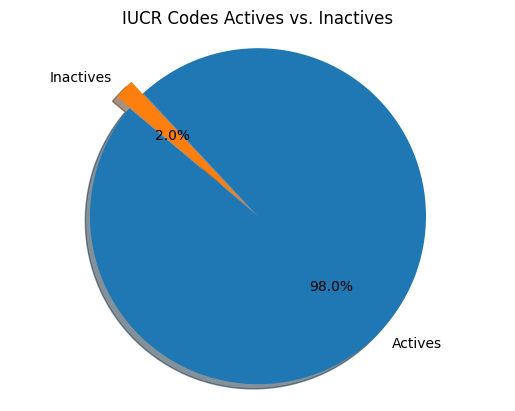

In [12]:

mycursor = conx.cursor()

query_actives = "SELECT COUNT(*) FROM codes WHERE active = 1"

query_inactives = "SELECT COUNT(*) FROM codes WHERE active = 0"


mycursor.execute(query_actives)
active = mycursor.fetchone()[0]

mycursor.execute(query_inactives)
inactive = mycursor.fetchone()[0]

print(active)
print(inactive)

mycursor.close()


labels = ['Actives', 'Inactives']
sizes = [active, inactive]
colors = plt.cm.tab10.colors
explode = (0.1, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  

plt.title('IUCR Codes Actives vs. Inactives')
plt.show()




The pie chart provides a visual representation of the distribution of IUCR codes according to their activity status, where "active" codes are those that are currently in use and "inactive" codes are those that have been retired but retained for historical reference. The graph shows that the vast majority of IUCR codes are active, accounting for 98% of the total, while only 2% are inactive.

In [68]:
mycursor = conx.cursor()

# iucr present in codes but not in crimes, that means, codes that don't appear in our dataset.
not_in_crimes = "SELECT iucr FROM codes EXCEPT SELECT iucr FROM crimes"

mycursor.execute(not_in_crimes)
results = mycursor.fetchall()

mycursor.close()

diff_iucr = pd.DataFrame(results, columns=['iucr'])

print(diff_iucr)

    iucr
0   0130
1   0272
2   0275
3   0452
4   0490
..   ...
89  5005
90  5009
91  5120
92  5121
93  5122

[94 rows x 1 columns]


We can see that out of 410 existent IUCR codes, 94 of them are not present in our crimes table.

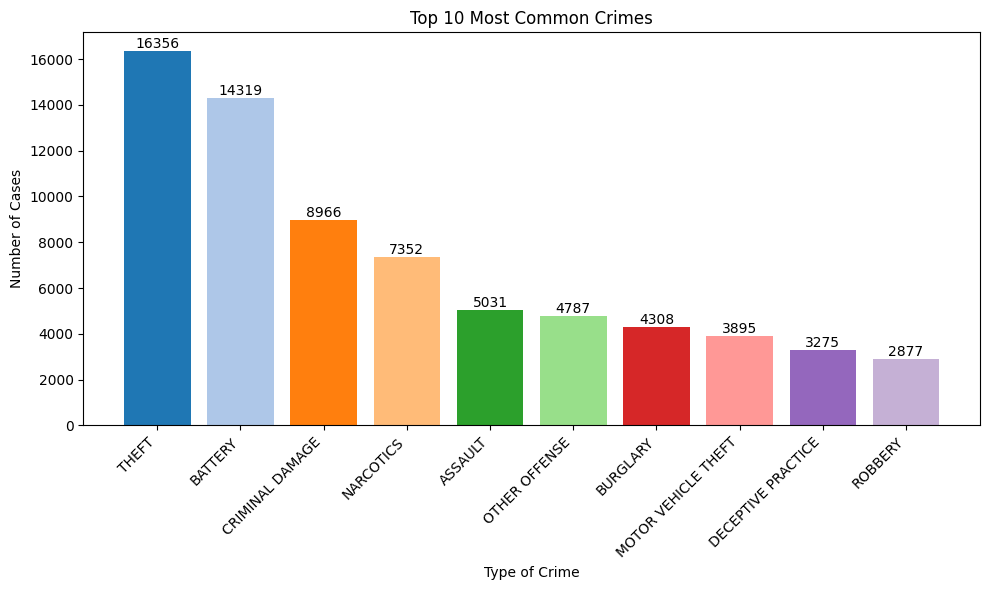

In [11]:
# Primary description con dimensions 

mycursor = conx.cursor()


top_10 = """
SELECT i.primary_description, COUNT(c.id) AS count
FROM crimes AS c
JOIN codes AS i ON c.iucr = i.iucr
GROUP BY i.primary_description
ORDER BY count DESC
LIMIT 10;
"""


mycursor.execute(top_10)

results = mycursor.fetchall()

mycursor.close()

top_10_crimes = pd.DataFrame(results, columns=['primary_description', 'count'])

color = plt.cm.tab20.colors
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_crimes['primary_description'], top_10_crimes['count'], color=color)
plt.ylabel('Number of Cases') 
plt.xlabel('Type of Crime') 
plt.title('Top 10 Most Common Crimes')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() * 0.5, bar.get_height(),
             f'{bar.get_height():.0f}',
             va='bottom', ha='center', fontsize=10, color='black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The most common crime in the city of Chicago between 2001 and 2023 was theft, with more than 16,000 reported cases. On the other hand, the least common crime during this period was robbery. The key difference between theft and robbery is the use of force or threat. Theft typically involves the unlawful taking of someone's property without the use of force, while robbery involves the use of force or intimidation to steal from a person or place.

108
302


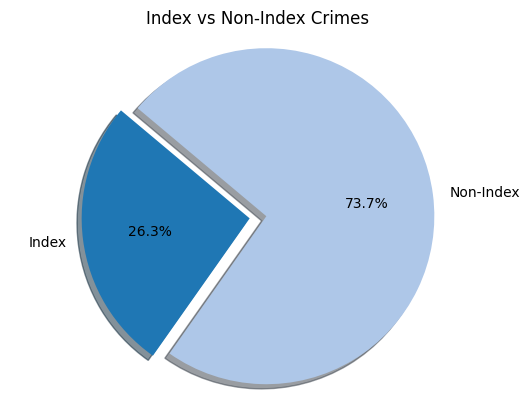

In [13]:
mycursor = conx.cursor()

query_index = "SELECT COUNT(*) FROM codes WHERE index_code = 'I'"

query_non_index = "SELECT COUNT(*) FROM codes WHERE index_code = 'N'"


mycursor.execute(query_index)
index = mycursor.fetchone()[0]

mycursor.execute(query_non_index)
non_index = mycursor.fetchone()[0]

print(index)
print(non_index)

mycursor.close()

labels = ['Index', 'Non-Index']
sizes = [index, non_index]
colors = plt.cm.tab20.colors
explode = (0.1, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  

plt.title('Index vs Non-Index Crimes')
plt.show()

The graph shows that 26.3% of crimes in Chicago are classified as "index crimes," which means they are serious crimes that typically receive increased scrutiny and follow-up by law enforcement. The remainder (73.7%), representing the majority of crimes, fall into the "non-index" category. This suggests that the majority of crimes in Chicago are less serious or less violent in nature compared to "index" crimes.